# Uncertain Mortality Model vs American Options

** Re-insurance Deals**

In this project, we only consider one type of default: the risk of death.

The considered reinsurance product is the following:

- At maturity, if the insurance subscriber is alive, the issuer delivers a Put on the underlying $X$

$$
u^\textrm{mat}( x) = (K_\textrm{mat} - x)_+.
$$

- At the time of death, if it is before the maturity, the issuer delivers an exit Payoff, typically another put on the underlying $X$.

$$
u^D(t, x) = (K_D - x)_+.
$$

- The insurance sells a large number of these contracts to subscribers. We assume that the times of death of the subscribers $\tau^D$ are independent, and identically distributed, and also independent of the underlying's stock price.

- We assume that the underlying's risk neutral price dynamics is the Black-Scholes model with zero interest rate/repo/dividend yield

$$
dX_t = \sigma X_t d W_t.
$$

** The Insurers' Approach and Risk-Neutral Pricing**

This contract shows too types risk: the time of death of the subscribers and the changes in price of the underlying. 

In this case, the issuer can apply the insurer's approach to the risk of death, i.e. the law of large numbers. The more people buy the contract, the less risk.

Choosing a risk-neutral measure under which the death times $\tau^D$ have the same distribution as under the historical probability measure is equivalent to applying the arbitrage-pricing approach to the financial risk insurer's rule on the risk of death. The price of the contract is then

$$
u(t, x) = E^\mathbb{Q}_{t, x} \left[u^\textrm{mat}(X_T) \mathbb{1}_{\tau^D \geq T} + u^D(\tau^D, X_{\tau^D}) \mathbb{1}_{\tau^D < T} \right].
$$

** Deterministic Death Rate **

If the death intensity is a deterministic function $\lambda_t^D$ (i.e. $\tau^D$ has an exponential distribution with time-dependent intensity $\lambda_t^D$), then we have seen that $u$ is the solution to the linear PDE

$$
\left\{\begin{array}{l}
\partial_t u + \frac{1}{2} \sigma^2 x^2 \partial_x^2 u + \lambda_t^D \cdot (u^D - u) = 0,\\
u(T, \cdot) \equiv u^\textrm{mat}.
\end{array}\right.
$$

** Uncertain Mortality Model **

We now assume that the death rate is uncertain. We assume that it is adapted and remains in the deterministic interval
$\left[\underline{\lambda}_t, \overline{\lambda}_t\right]$. The most conservative way to price the contract is to compute the (financially) worth death rate process $\lambda_t^D$ as being chosen so as to maximize the value of the contract. The resulting HJB equation is

$$
\left\{\begin{array}{l}
\partial_t u + \frac{1}{2} \sigma^2 x^2 \partial^2_x u + \lambda^D(t, u^D - u) \cdot (u^D - u) = 0,\\
u(T, \cdot) \equiv u^\textrm{mat},
\end{array}\right.
$$
where
$$
\lambda^D (t, y) = \left\{\begin{array}{l} 
    \overline{\lambda}^D_t \quad \textrm{if} \ y \geq 0, \\
    \underline{\lambda}^D_t \quad \textrm{otherwise.}
\end{array}\right.
$$

** Link with $1$-BSDE and Numerical Schemes **

From the Pardoux-Peng theorem, we know that the solution $u(0, x)$ can be represented as the solution $Y_0^x$ to the $1$-BSDE

$$
dY_t = -f(t, X_t, Y_t, Z_t) dt + Z_t dW_t,
$$

with the terminal condition $Y_T = u^\textrm{mat} (X_T)$, where $X_0 = x$ and

$$
f(t, x, y, z) = \lambda^D(t, u^D(t, x) - y) \cdot (u^D(t, x) - y).
$$

## Some Simulation and Regression Routines

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

** Regression routines**

In [2]:
# Non-parametric regression function
def reg_non_param(x, bdwidth, x_sample, y_sample):
    """Values of the non-parametric regression of Y wrt X using a Gaussian kernel.

    Parameters
    ----------
    x: numpy array, one dimensional
        Values at which the regression is evaluated
    bdwidth: positive float, value of the bandwidth parameter
    x_sample: numpy array, one dimensional, non-empty
        x values of the sample
    y_sample: numpy array, one dimensional
        y values of the sample, must have the same length as x_sample.    
    """
    def kern(u, x):
        """Gaussian kernel function"""
        return np.exp(-(u[:, np.newaxis] - x) ** 2 / (2 * bdwidth ** 2))

    return np.sum(kern(x_sample, x) * y_sample[:, np.newaxis], axis=0) \
        / np.sum(kern(x_sample, x), axis=0)

In [3]:
def basis(knots, x):
    """Values of order-1 B-spline basis functions.
    
    For an increasingly sorted collection of knots and a collection of
    query points x, returns a 2-dimensional array of values, of dimension
    len(x) x len(knots).
    
    Parameters
    ----------
    knots: numpy array, one dimensional, increasingly sorted
        Knots of the B-spline function
    x: numpy array, one dimensional
        Query points where to evaluate the basis functions.
    """
    nb_knots = len(knots)
    diag = np.identity(nb_knots)
    res = np.empty((len(x), nb_knots))
    for i in xrange(nb_knots):
        res[:, i] = np.interp(x, knots, diag[i])
    return res

In [4]:
def reg_param_coeffs(knots, x_sample, y_sample):
    """Computes the coefficients of the P-L regression of y_sample wrt. x_sample.
    
    For an increasingly sorted collection of knots and two one-dimensional
    samples x_sample and y_sample, computes the PL-regression.
    
    Parameters
    ----------
    knots: numpy array, one dimensional, increasingly sorted
        Knots of the B-spline function
    x_sample: numpy array, one dimensional
        X sample
    y_sample: numpy array, one dimensional
        Y sample
        
    Notes
    -----
    The length of the X and Y samples must be the same.
    The length of the knots array should be at least one.
    The knots must be increasingly sorted.
    """
    bis = basis(knots, x_sample)
    var = bis.T.dot(bis)
    covar = y_sample.dot(bis)
    return np.linalg.lstsq(var, covar.T)[0]

In [5]:
def eval_piecewise_linear(x, knots, coeffs):
    """Eveluates the piecewise linear function at the specified x for the
    specified knots and coeffs.
    
    This is simply a wrapper around np.interp.
    """
    return np.interp(x, knots, coeffs)

**Simulation routines for Black-Scholes paths**

In [6]:
## Utility function for simulating Black-Scholes paths

def bs_path(nb_step, nb_mc, S0, sigma, T):
    """Simulate geometric Brownian motion
    
    Parameters
    ----------
    nb_step: integer, greater than 1
        number of time steps
    nb_mc: positive integer
        sample size
    S0: positive float
        starting value
    r: float
        drift
    sigma: float
        volatility
    T: positive float
        maturity
    """
    brownian = np.empty((nb_step + 1, nb_mc))
    brownian[0] = 0.0
    brownian[1:] = np.cumsum(np.random.randn(nb_step, nb_mc), axis=0) * np.sqrt(T / nb_step)

    return S0 * np.exp(sigma * brownian + (- 0.5 * sigma ** 2) * np.linspace(0.0, T, nb_step + 1)[:, np.newaxis])

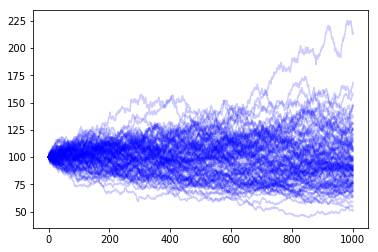

In [7]:
plt.figure()
nb_step=1000; nb_mc=100; S0=100; sigma=0.3; T=1.0
ss = bs_path(nb_step, nb_mc, S0, sigma, T)
plt.plot(ss, 'b', alpha=0.2)
plt.show()

## BSDE Discretization

### Explicit Euler Schemes

$$
Y_{t_{i - 1}} = E^\mathbb{Q}_{i - 1} [ Y_{t_i} ] + \lambda^D (t_{i - 1}, u^D(t_{i - 1} , X_{t_{i - 1}}) -E^\mathbb{Q}_{i - 1} [ Y_{t_i} ]) \cdot \left( u^D(t_{i - 1}, X_{t_{i - 1}}) - E^\mathbb{Q}_{i - 1} [ Y_{t_i} ] \right) \Delta t_i.
$$

Using the actual formula for $\overline{\lambda}$ and $\underline{\lambda}$, this comes to

$$
\begin{array}{l}
Y_{t_{i - 1}} & = \left( E^\mathbb{Q}_{i - 1} [ Y_{t_i} ] \left( 1 - \overline{\lambda}^D \Delta t_i \right) +
u^D(t_{i - 1}, X_{t_{i - 1}}) \overline{\lambda}^D \Delta t_i \right) \mathbb{1}_{u^D(t_{i - 1}, X_{t_{i - 1}}) \geq E_{i-1}[Y_{t_i}]}\\
& + \left( E^\mathbb{Q}_{i - 1} [ Y_{t_i} ] \left( 1 - \underline{\lambda}^D \Delta t_i \right) +
u^D(t_{i - 1}, X_{t_{i - 1}}) \underline{\lambda}^D \Delta t_i \right) \mathbb{1}_{u^D(t_{i - 1}, X_{t_{i - 1}}) < E_{i-1}[Y_{t_i}]}.
\end{array}
$$

### Implicit Euler Scheme

$$
Y_{t_{i - 1}} = E^\mathbb{Q}_{i - 1} [Y_{t_i}] + \lambda^D (t_{i - 1}, u^D(t_{i - 1}, X_{t_{i - 1}}) - Y_{t_{i - 1}}) \cdot \left( u^D(t_{i - 1}, X_{t_{i - 1}}) - Y_{t_{i - 1}} \right) \Delta t_i.
$$

The implicit scheme involves the $Y_{t_{i - 1}}$ on both sides of the equation, which generally requires numerically finding roots, but in this specific case, using the explicit formula for $\overline{\lambda}$ and $\underline{\lambda}$, this comes to

$$
\begin{array}{l}
Y_{t_{i - 1}} & = \frac{1}{1 + \overline{\lambda}^D \Delta t_i} \left( E^\mathbb{Q}_{i - 1} [ Y_{t_i} ] +
u^D(t_{i - 1}, X_{t_{i - 1}}) \overline{\lambda}^D \Delta t_i \right) \mathbb{1}_{u^D(t_{i - 1}, X_{t_{i - 1}}) \geq E_{i-1}[Y_{t_i}]}\\
& + \frac{1}{1 + \underline{\lambda}^D \Delta t_i} \left( E^\mathbb{Q}_{i - 1} [ Y_{t_i} ] +
u^D(t_{i - 1}, X_{t_{i - 1}}) \underline{\lambda}^D \Delta t_i \right) \mathbb{1}_{u^D(t_{i - 1}, X_{t_{i - 1}}) < E_{i-1}[Y_{t_i}]}.
\end{array}
$$



In [8]:
# Model
S0 = 100.0
sigma = 0.3
T = 10.0

# Payoff: Put
Kmat = 90.0
KD = 100.0

def umat(x):
    return np.maximum(Kmat - x, 0)

def uD(x):
    return np.maximum(KD - x, 0)

# Sample size and time discretization
nb_mc = 4000
nb_step = 10

lambdamin, lambdamax = 0.005, 0.04

In [9]:
# Native implicit BSDE discretization for uncertain mortality model

path = bs_path(nb_step, nb_mc, S0, sigma, T)
y = umat(path[-1])
deltat = T / nb_step

# Backward induction
for index in range(nb_step):
    i = nb_step - index - 1
    if i != 0:
        ycond = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], y)
    else:
        ycond = np.mean(y)
    death = uD(path[i])
    y = np.where(death > ycond, 
                (ycond + death * lambdamax * deltat) / (1.0 + lambdamax * deltat),
                (ycond + death * lambdamin * deltat) / (1.0 + lambdamin * deltat))

print('Price from backward induction (non-parametric): ', np.mean(y))

Price from backward induction (non-parametric):  31.3682869358


## Numerical Experiments

In [15]:
#from ipywidgets import interact
#from pylab import *
import random

### 1. Deterministic Mortality Rate Model
- Using a naive simulation of the death time for each path, implement a Monte Carlo simulation to estimate the quantity
    $$u(t, x) = E^\mathbb{Q}_{t, x} \left[u^\textrm{mat}(X_T) \mathbb{1}_{\tau^D \geq T} + u^D(\tau^D, X_{\tau^D}) \mathbb{1}_{\tau^D < T} \right],
    $$
    when $\tau^D$ has an exponential distribution of constant intensity $\lambda^D$. Use the formula above, we have the formula for $u(0,x)$ as following:
    $$u(0, x) = E^\mathbb{Q}\left[u^\textrm{mat}(X_T) \mathbb{1}_{\tau^D \geq T} + u^D(\tau^D, X_{\tau^D}) \mathbb{1}_{\tau^D < T}|X_0=x \right],
    $$

In [18]:
def naive_simulation_of_death_time(lambda_D):
    global path, nb_mc, T
    y = umat(path[-1])
    for i in range(nb_mc):
        # generate exponential random variable
        tau_D = random.expovariate(lambda_D)
        if tau_D < T:
            y[i] = uD(path[int(tau_D), i])
    print("lambda^D = ", lambda_D)
    print('Price from naive simulation of the death time: ', np.mean(y))
    
# test the result when lambda^D = lambda_min
naive_simulation_of_death_time(lambdamin)

lambda^D =  0.005
Price from naive simulation of the death time:  29.2915371907


- Using the Feynman-Kac formula, derive a stochastic representation of the linear PDE
    $$
    \left\{\begin{array}{l}
    \partial_t u + \frac{1}{2} \sigma^2 x^2 \partial_x^2 u + \lambda_t^D \cdot (u^D - u) = 0,\\
    u(T, \cdot) \equiv u^\textrm{mat}.
    \end{array}\right.,
    $$
    Implement the corresponding Monte Carlo simulation. By Feynman-Kac , the solution to the PDE above can be written as a conditional expectation
    $$
    u(t,x) = E^Q_{t,x}\left[\int_t^T e^{-\int_t^r \lambda_\tau^Dd\tau}\lambda_r^D\cdot u^D(X_r,r)dr+e^{-\int_t^T \lambda_\tau^Dd\tau}u^{mat}(X_T)\right] 
    $$
    under the probability measure $Q$ such that $X$ is an Ito process driven by the equation
    $$
    dX=\sigma XdW^Q
    $$
    When $\tau^D$ has an exponential distribution of constant intensity $\lambda^D$ and $t=0$, the above formula becomes
    $$
    u(0,x) = E^Q\left[\int_0^T e^{-\lambda^D t}\lambda^D\cdot u^D(X_t)dt+e^{-\lambda^DT}u^{mat}(X_T)|X_0=x\right]
    $$
    Moreover, if we discretize [0,T], namely, $0=t_0<\cdots<t_n=T,~t_i=\frac{i}{n}T, \Delta t = \frac{T}{n}$, the integral can be approximated by Monte Carlo paths
    $$
    ~\int_0^T e^{-\lambda^D t}\lambda^D\cdot u^D(X_t)dt=\sum_{i=0}^{n-1} e^{-\lambda^D t_i}\lambda^D\cdot u^D(X_{t_i})\frac{T}{n}
    $$
    Finally, we can estimate $u(0,x)$ by averaging the results.

In [12]:
def Feynmann_Kac(lambda_D):
    global path, nb_mc, nb_step, T
    ti = np.linspace(0.0, T, nb_step + 1)
    y = np.exp(-lambda_D*T)*umat(path[-1])
    for i in range(nb_step):
        y += np.exp(-lambda_D*ti[i]) * lambda_D * uD(path[i]) * T / nb_step
    print("lambda^D = ", lambda_D)
    print('Price from using the Feynman-Kac formula: ', np.mean(y))
    
# test the result when lambda^D = lambda_min
Feynmann_Kac(lambdamin)

lambda^D =  0.005
Price from using the Feynman-Kac formula:  29.5008324882


### 2. Uncertain Mortality Rate Model
- From the numerical results below, we find that if $\lambda^D \in \left[\underline{\lambda}, \overline{\lambda} \right]$, the price of uncertain mortality rate model is larger than the price of deterministic mortality rate model.

In [13]:
# Uncertain mortality rate model
print('Price from backward induction (non-parametric): ', np.mean(y))

Price from backward induction (non-parametric):  31.4849548592


In [14]:
# Deterministic mortality rate model: a naive simulation of the death time
interact(naive_simulation_of_death_time, lambda_D = (lambdamin, lambdamax, 0.001))

lambda^D =  0.022
Price from naive simulation of the death time:  28.2581268252


<function __main__.naive_simulation_of_death_time>

In [15]:
# Deterministic mortality rate model: Feynman-Kac formula
interact(Feynmann_Kac, lambda_D = (lambdamin, lambdamax, 0.001))

lambda^D =  0.022
Price from using the Feynman-Kac formula:  28.3464251488


<function __main__.Feynmann_Kac>

- From the numerical results below, we can find that the price becomes larger when the interval widens.

In [16]:
# Native implicit BSDE discretization for uncertain mortality model
def BSDE(lambdamin, lambdamax):
    global path, nb_step, T
    y = umat(path[-1])
    deltat = T / nb_step
    
    # Backward induction
    for index in range(nb_step):
        i = nb_step - index - 1
        if i != 0:
            ycond = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], y)
        else:
            ycond = np.mean(y)
        death = uD(path[i])
        y = np.where(death > ycond, 
                    (ycond + death * lambdamax * deltat) / (1.0 + lambdamax * deltat),
                    (ycond + death * lambdamin * deltat) / (1.0 + lambdamin * deltat))
    print("lambdamin = ", lambdamin, ", lambda_max = ", lambdamax)
    print('Price from backward induction (non-parametric): ', np.mean(y))

# interact with lambda_min, lambda_max
interact(BSDE, lambdamin = (0.0005, 0.005, 0.0001), lambdamax = (0.04, 0.4, 0.01))

lambdamin =  0.0027 , lambda_max =  0.22
Price from backward induction (non-parametric):  35.3187451733


<function __main__.BSDE>

- From the numerical results below, we can see that corresponding American option price should be larger than the price of the reinsurance deal.

In [17]:
# Lonstaff-Schwartz Algorithm for American option
price = umat(path[-1])
for index in range(nb_step):
    i = nb_step - index - 1
    exercise = uD(path[i])
    if i != 0:
        continuation = reg_non_param(path[i], 0.3 * np.std(path[i]), path[i], price)
    else:
        continuation = np.mean(price)
    exercise_now = exercise > continuation
    price = np.where(exercise_now, exercise, price)

print('American option price from Lonstaff-Schwartz Algorithm (non-parametric): ', np.mean(price))
print('Reinsurance deal price from backward induction (non-parametric): ', np.mean(y))

American option price from Lonstaff-Schwartz Algorithm (non-parametric):  33.9881587723
Reinsurance deal price from backward induction (non-parametric):  31.4849548592


- Compare the corresponding American semi-linear PDE with the HJB equation derived earlier. What should the limit be when $\underline{\lambda}$ and $\overline{\lambda}$ go to zero and infinity respectively? The HJB equation derived earlier is

    $$
    \left\{\begin{array}{l}
    \partial_t u + \frac{1}{2} \sigma^2 x^2 \partial^2_x u + \lambda^D(t, u^D - u) \cdot (u^D - u) = 0,\\
    u(T, \cdot) \equiv u^\textrm{mat}.
    \end{array}\right.
    $$
    where
    $$
    \lambda^D (t, y) = \left\{\begin{array}{l} 
        \overline{\lambda}^D_t \quad \textrm{if} \ y \geq 0, \\
        \underline{\lambda}^D_t \quad \textrm{otherwise.}
    \end{array}\right.
    $$
    When $\underline{\lambda}$ and $\overline{\lambda}$ go to zero and infinity respectively, the HJB equation becomes
    $$
    \left\{\begin{array}{l}
    \max(\partial_t u + \frac{1}{2} \sigma^2 x^2 \partial^2_x u,~u^D - u) = 0,\\
    u(T, \cdot) \equiv u^\textrm{mat}.
    \end{array}\right.
    $$
    which is the variational inequality of American semi-linear PDE except that the exercise payoff is $u^D$ and the terminal condition is $u^\textrm{mat}$.
    

- Compute the critical value $X_t^*$ of $X_t$ under which the worst case scenario for the issuer corresponds to the maximal mortality rate. Plot the value of $X_t^*$ as a function of $t$.

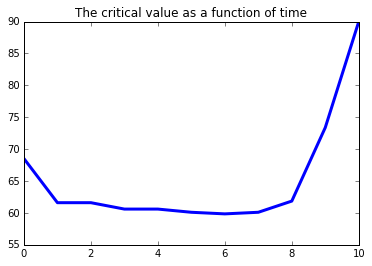

In [18]:
y = umat(path[-1])
deltat = T / nb_step
mesh = np.linspace(20.0, 120.0, 400)
critical_v_0 = [Kmat]

# Backward induction
for index in range(nb_step):
    i = nb_step - index - 1
    if i != 0:
        ycond = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], y)
        ycond_mesh = reg_non_param(mesh, 0.2 * np.std(path[i]), path[i], y)
        death_mesh = uD(mesh)
        critical_v_0.insert(0, mesh[death_mesh > ycond_mesh][-1])
    else:
        ycond = np.mean(y)
    death = uD(path[i])
    y = np.where(death > ycond, 
                (ycond + death * lambdamax * deltat) / (1.0 + lambdamax * deltat),
                (ycond + death * lambdamin * deltat) / (1.0 + lambdamin * deltat))

critical_v_0.insert(0, KD - np.mean(y))
plt.plot(np.linspace(0, T, nb_step + 1), critical_v_0, linewidth=3)
plt.title("The critical value as a function of time")

### 3.Including a fee in the product
- Modify the above BSDE discretization to account for the possibility of a constant fee $\alpha \Delta t$ paid by the subscribers at every time step until death or the maturity or the product. Investigate the dependence of the cricial value $X_t^*$ with respect to the value of the fee. When a constant fee $\alpha \Delta t$ paid by the subscribers at every time step until death or the maturity or the product, the HJB equation becomes

    $$
    \left\{\begin{array}{l}
    \partial_t u + \frac{1}{2} \sigma^2 x^2 \partial^2_x u - \alpha + \lambda^D(t, u^D - u) \cdot (u^D - u) = 0,\\
    u(T, \cdot) \equiv u^\textrm{mat},
    \end{array}\right.
    $$
    From the Pardoux-Peng theorem, we know that the solution $u(0, x)$ can be represented as the solution $Y_0^x$ to the $1$-BSDE

    $$
    dY_t = -f(t, X_t, Y_t, Z_t) dt + Z_t dW_t,
    $$

    with the terminal condition $Y_T = u^\textrm{mat} (X_T)$, where $X_0 = x$ and

    $$
    f(t, x, y, z) = \lambda^D(t, u^D(t, x) - y) \cdot (u^D(t, x) - y) - \alpha.
    $$
    
    We have the Implicit Euler Scheme

    $$
    Y_{t_{i - 1}} = E^\mathbb{Q}_{i - 1} [Y_{t_i}] +\left[ \lambda^D (t_{i - 1}, u^D(t_{i - 1}, X_{t_{i - 1}}) - Y_{t_{i - 1}}) \cdot \left( u^D(t_{i - 1}, X_{t_{i - 1}}) - Y_{t_{i - 1}} \right) -\alpha \right]\Delta t_i.
    $$

    The implicit scheme involves the $Y_{t_{i - 1}}$ on both sides of the equation, which generally requires numerically finding roots, but in this specific case, using the explicit formula for $\overline{\lambda}$ and $\underline{\lambda}$, this comes to

    $$
    \begin{array}{l}
    Y_{t_{i - 1}} & = \frac{1}{1 + \overline{\lambda}^D \Delta t_i} \left[ E^\mathbb{Q}_{i - 1} [ Y_{t_i} ] +
    \left(u^D(t_{i - 1}, X_{t_{i - 1}}) \overline{\lambda}^D-\alpha \right) \Delta t_i \right] \mathbb{1}_{u^D(t_{i - 1}, X_{t_{i - 1}}) \geq E_{i-1}[Y_{t_i}]}\\
    & + \frac{1}{1 + \underline{\lambda}^D \Delta t_i} \left[ E^\mathbb{Q}_{i - 1} [ Y_{t_i} ] +
    \left(u^D(t_{i - 1}, X_{t_{i - 1}}) \underline{\lambda}^D -\alpha \right)\Delta t_i \right] \mathbb{1}_{u^D(t_{i - 1}, X_{t_{i - 1}}) < E_{i-1}[Y_{t_i}]}.
    \end{array}
    $$
    
    From the plot below, we can find that the critical value $X_t^*$ increases as the fee $\alpha$ increases. More specifically, the critical value $X_t^*$ increases by approximately $(T - t)*\alpha$ when compared to the critical value value without fee.

Fee alpha =  0.99


<function __main__.BSDE_Critical_Value_Alpha>

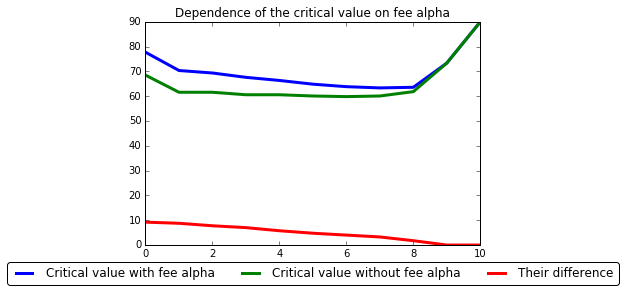

In [19]:
# Native implicit BSDE discretization for uncertain mortality model with constant fee alpha 
def BSDE_Critical_Value_Alpha(alpha):
    global path, nb_step, lambdamin, lambdamax, T, critical_v_0
    y = umat(path[-1])
    deltat = T / nb_step
    mesh = np.linspace(20.0, 120.0, 400)
    critical_v = [Kmat]
    
    # Backward induction
    for index in range(nb_step):
        i = nb_step - index - 1
        if i != 0:
            ycond = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], y)
            ycond_mesh = reg_non_param(mesh, 0.2 * np.std(path[i]), path[i], y)
            death_mesh = uD(mesh)
            critical_v.insert(0, mesh[death_mesh > ycond_mesh][-1])
        else:
            ycond = np.mean(y)
        death = uD(path[i])
        y = np.where(death > ycond, 
                    (ycond + (death * lambdamax - alpha) * deltat) / (1.0 + lambdamax * deltat),
                    (ycond + (death * lambdamin - alpha) * deltat) / (1.0 + lambdamin * deltat))
    critical_v.insert(0, KD - np.mean(y))
    
    # Plot the cricial value with/witout fee alpha
    print("Fee alpha = ", alpha)
    xaxis = np.linspace(0, T, nb_step + 1)
    plt.plot(xaxis, critical_v, linewidth=3, label = "Critical value with fee alpha")
    plt.plot(xaxis, critical_v_0, linewidth=3, label = "Critical value without fee alpha")
    plt.plot(xaxis, np.array(critical_v) - np.array(critical_v_0), linewidth=3, label = "Their difference")
    legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox = True, ncol=5)
    plt.title("Dependence of the critical value on fee alpha")
    
interact(BSDE_Critical_Value_Alpha, alpha = (0.0, 2.0, 0.01))